TCR-pMHC binding prediction challenge (Copenhagen Biohackathon 2021)

Building a baseline model using tensorflow

In [ ]:
!git clone https://github.com/d-vora/tcr-pmhc.git

Cloning into 'tcr-pmhc'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 311 (delta 33), reused 24 (delta 24), pack-reused 266
Receiving objects: 100% (311/311), 70.74 MiB | 36.40 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Checking out files: 100% (20/20), done.


In [ ]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix
# import torch
# import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
# import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
# import torch.nn.functional as F  # All functions that don't have any parameters

In [ ]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters

In [ ]:
!unzip '/content/tcr-pmhc/data/train.zip'

Archive:  /content/tcr-pmhc/data/train.zip
  inflating: P2_labels.npz           
   creating: __MACOSX/
  inflating: __MACOSX/._P2_labels.npz  
  inflating: P3_input.npz            
  inflating: __MACOSX/._P3_input.npz  
  inflating: P4_input.npz            
  inflating: __MACOSX/._P4_input.npz  
  inflating: P2_input.npz            
  inflating: __MACOSX/._P2_input.npz  
  inflating: P1_input.npz            
  inflating: __MACOSX/._P1_input.npz  
  inflating: P3_labels.npz           
  inflating: __MACOSX/._P3_labels.npz  
  inflating: P4_labels.npz           
  inflating: __MACOSX/._P4_labels.npz  
  inflating: P1_labels.npz           
  inflating: __MACOSX/._P1_labels.npz  


## Model

In [ ]:
###############################
###    Load data            ###
###############################

data_list = []
target_list = []

import glob
for fp in glob.glob("/content/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    
    data_list.append(data)
    target_list.append(targets)

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)
#device = torch.device("cpu")


Training set shape: 4538 420 54
val set shape: 1168 420 54
Percent positive samples in train: 24.9669457910974
Percent positive samples in val: 25.0

NOTE:
Setting batch-size to 64
Using device (CPU/GPU): cpu


In [ ]:
yt = y_train
yv = y_val

In [ ]:
X_rtrain = X_train.reshape((4538, 22680))
X_rval = X_val.reshape((1168, 22680))

In [ ]:
from sklearn.preprocessing import RobustScaler

X_rtrain = RobustScaler().fit_transform(X_rtrain)
X_rval = RobustScaler().fit_transform(X_rval)

In [ ]:
x_train = X_rtrain.reshape(X_train.shape[0], 420, 54)
x_val = X_rval.reshape(X_val.shape[0], 420, 54)

In [ ]:
from keras.utils import np_utils
number_of_classes =2

y_train = np_utils.to_categorical(y_train, number_of_classes)
y_val = np_utils.to_categorical(y_val, number_of_classes)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Concatenate, Flatten, GlobalAveragePooling1D, MaxPooling2D, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, LSTM, GRU, Bidirectional, Lambda
from keras.regularizers import l2,l1
from keras.optimizers import SGD,Adam,RMSprop
from tensorflow.compat.v1 import InteractiveSession
import keras.backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model
import keras.metrics

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 706kB 19.5MB/s 


In [ ]:
#now model
def clear_sess():
  try:
    del model, history
  except:
    pass
  from keras import backend as K
  K.clear_session()
  return None

In [ ]:
opt = Adam(lr =0.0002)
model = Sequential()
model.add(Conv1D(32, 3, input_shape =(420, 54)))
model.add(Conv1D(32, 3, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
print(model.summary())

es = EarlyStopping(monitor='accuracy', mode='max', patience=10, verbose=1)

model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.75, gamma = 1.5), optimizer = opt, metrics=["accuracy"])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 418, 32)           5216      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 416, 32)           3104      
_________________________________________________________________
dropout_5 (Dropout)          (None, 416, 32)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 208, 32)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6656)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               665700    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                

In [ ]:
model.fit(x_train, y_train, epochs= 150, callbacks=[es], verbose=2)

Epoch 1/150
142/142 - 6s - loss: 0.7091 - accuracy: 0.7492
Epoch 2/150
142/142 - 5s - loss: 0.6314 - accuracy: 0.8129
Epoch 3/150
142/142 - 5s - loss: 0.6152 - accuracy: 0.8354
Epoch 4/150
142/142 - 5s - loss: 0.6012 - accuracy: 0.8552
Epoch 5/150
142/142 - 5s - loss: 0.5893 - accuracy: 0.8691
Epoch 6/150
142/142 - 5s - loss: 0.5793 - accuracy: 0.8797
Epoch 7/150
142/142 - 5s - loss: 0.5692 - accuracy: 0.8859
Epoch 8/150
142/142 - 5s - loss: 0.5583 - accuracy: 0.9048
Epoch 9/150
142/142 - 5s - loss: 0.5484 - accuracy: 0.9101
Epoch 10/150
142/142 - 5s - loss: 0.5403 - accuracy: 0.9204
Epoch 11/150
142/142 - 5s - loss: 0.5321 - accuracy: 0.9332
Epoch 12/150
142/142 - 5s - loss: 0.5234 - accuracy: 0.9436
Epoch 13/150
142/142 - 5s - loss: 0.5183 - accuracy: 0.9495
Epoch 14/150
142/142 - 5s - loss: 0.5120 - accuracy: 0.9544
Epoch 15/150
142/142 - 5s - loss: 0.5108 - accuracy: 0.9553
Epoch 16/150
142/142 - 5s - loss: 0.5064 - accuracy: 0.9617
Epoch 17/150
142/142 - 5s - loss: 0.5038 - accura

In [ ]:
loss, acc = model.evaluate(x_train, y_train) # for training data
print(loss, acc)

142/142 [==============================] - 2s 11ms/step - loss: 0.5013 - accuracy: 0.9641
0.5013085603713989 0.9640811085700989


In [ ]:
loss_val, acc_val = model.evaluate(x_val, y_val)
print(loss_val, acc_val)

37/37 [==============================] - 0s 12ms/step - loss: 0.9931 - accuracy: 0.8459
0.9930638670921326 0.8458904027938843


In [ ]:
yv_pred = model.predict_classes(x_val)

yt_pred = model.predict_classes(x_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
import seaborn as sns
# m = confusion_matrix(yv, yv_pred)

m = [[3397 8][31 1102]]
plt.figure(figsize=(16,9))
ax = plt.subplot()
sns.heatmap(m, ax=ax)

ax.set_xlabel("Pred Labels", size=20)
ax.set_ylabel("True Labels", size=20)

print(m)

In [ ]:
from sklearn.metrics import matthews_corrcoef
print('TRAINING MCC             ', round(matthews_corrcoef(yt, yt_pred),4))
print('VAL     MCC             ', round(matthews_corrcoef(yv, yv_pred),4))

TRAINING MCC              0.9033
VAL     MCC              0.565


## MH

MCC Train: 0.24774409929398966
MCC Test: 0.02391140499294052
Confusion matrix train:
[[3158  247]
 [ 841  292]]
Confusion matrix test:
[[875   1]
 [291   1]]


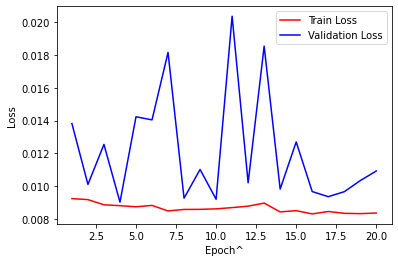

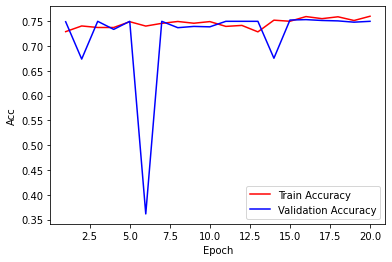

In [ ]:
###############################
###        PERFORMANCE      ###
###############################

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, losses, 'r', epoch, val_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch^'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

#print("Train accuracy:", train_acc, sep = "\n")
#print("Validation accuracy:", valid_acc, sep = "\n")

from sklearn.metrics import matthews_corrcoef
print("MCC Train:", matthews_corrcoef(train_targs, train_preds))
print("MCC Test:", matthews_corrcoef(val_targs, val_preds))

print("Confusion matrix train:", confusion_matrix(train_targs, train_preds), sep = "\n")
print("Confusion matrix test:", confusion_matrix(val_targs, val_preds), sep = "\n")

In [ ]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()

Text(0.5, 1.0, 'Validation AUC')

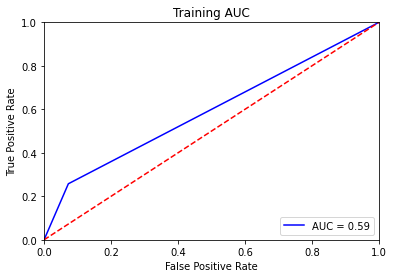

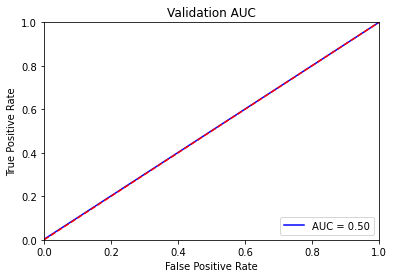

In [ ]:
plot_roc(train_targs, train_preds)
plt.title("Training AUC")
plot_roc(val_targs, val_preds)
plt.title("Validation AUC")